In [9]:
from fl_puf.Utils.tabular_data_loader import load_dutch 
import matplotlib.pyplot as plt

In [5]:
df, columns, metadata = load_dutch(dataset_path="./data/Tabular/dutch/")

In [6]:
df.head()

,age,household_position,household_size,prev_residence_place,citizenship,country_birth,edu_level,economic_status,cur_eco_activity,Marital_status,sex_binary,occupation_binary
0,6,1131,112,1,1,1,5,111,135,1,1,0
1,10,1122,113,1,1,1,2,111,122,2,0,1
2,8,1122,113,1,1,1,2,111,122,2,1,0
3,12,1121,112,1,1,1,1,111,137,2,1,1
4,4,1110,114,1,1,1,2,111,138,1,0,1


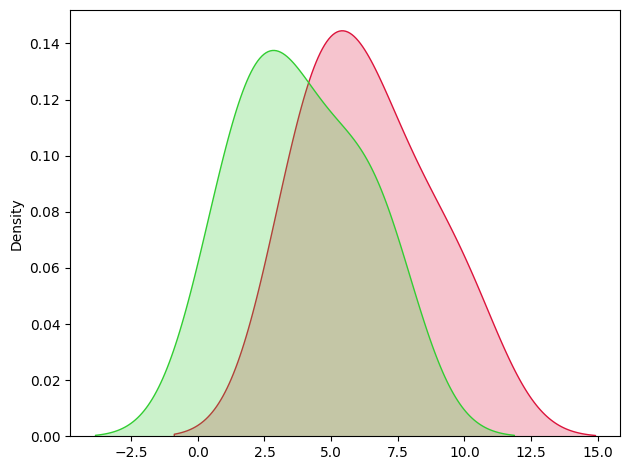

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.kdeplot(data=[4,6,8,10,4,6],
            color='crimson', label='train', fill=True)
sns.kdeplot(data=[1,2,3,4,6,7],
            color='limegreen', label='valid', fill=True)
    
# ticks
ax.set_xticks([0,1,2,3,4,5])


plt.tight_layout()
plt.show()

<Axes: >

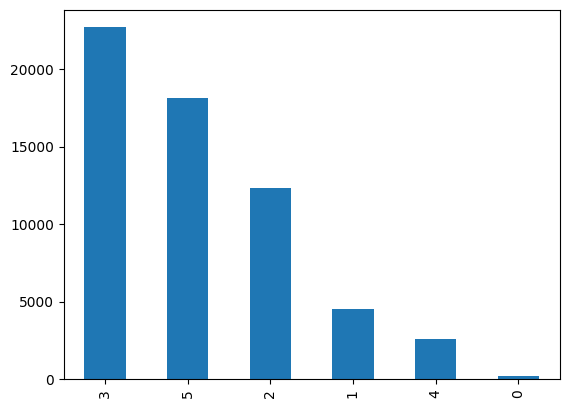

In [15]:
df.edu_level.value_counts().plot(kind='bar')

In [7]:
metadata

{'name': 'Dutch census',
 'code': ['DU1'],
 'protected_atts': ['sex_binary'],
 'protected_att_values': [0],
 'protected_att_descriptions': ['Gender = Female'],
 'target_variable': 'occupation_binary'}

In [12]:
df.drop("occupation_binary", axis=1).apply(lambda x: x.corr(df.occupation_binary))


age                    -0.261036
household_position     -0.036717
household_size         -0.011307
prev_residence_place   -0.015209
citizenship             0.036975
country_birth           0.062500
edu_level              -0.560657
economic_status        -0.215863
cur_eco_activity        0.034301
Marital_status         -0.086747
sex_binary             -0.298820
dtype: float64

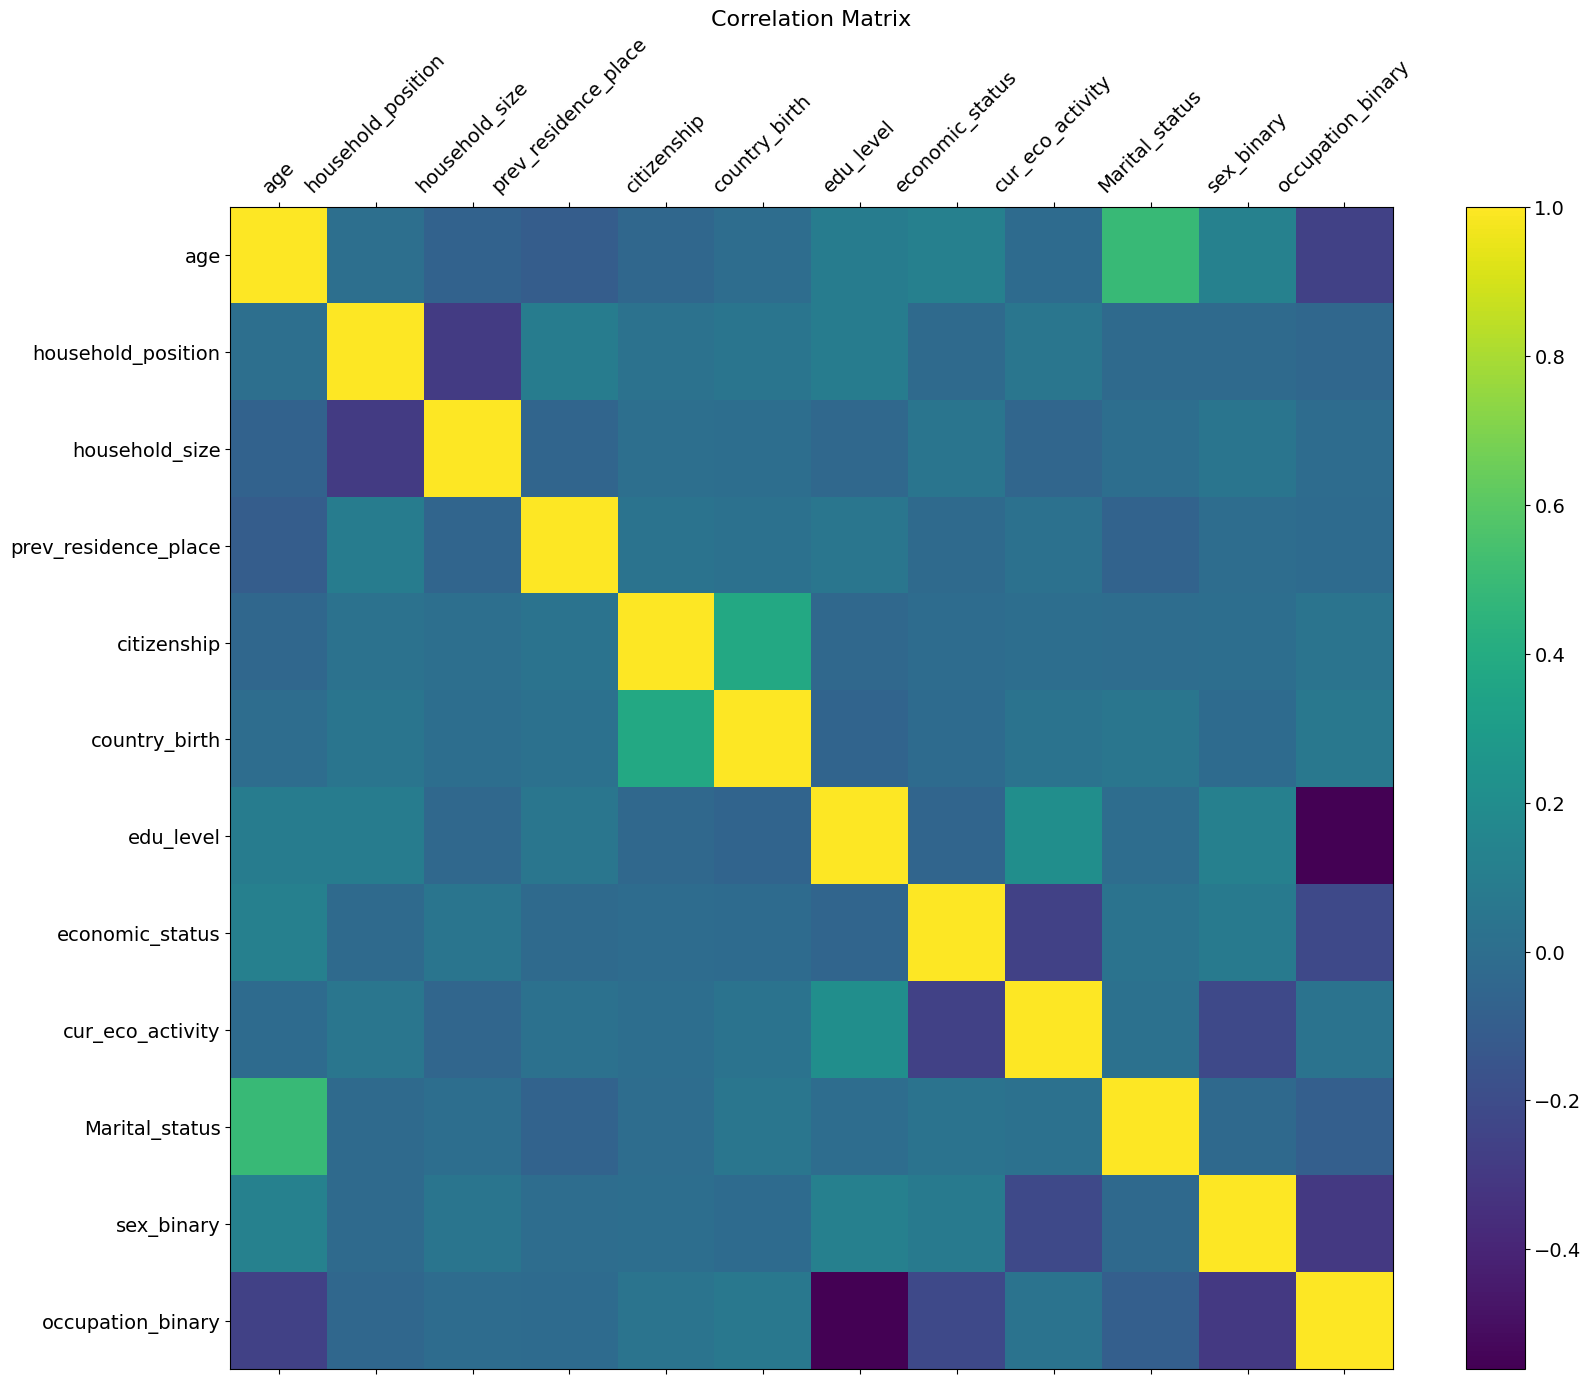

In [11]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);